In this lab, you will build four models and train it on the IMDB Reviews dataset with full word encoding. These use different layers after the embedding namely Flatten, LSTM, GRU, and Conv1D. You will compare the performance and see which architecture might be best for this particular dataset. Let's begin!

Imports



You will first import common libraries that will be used throughout the exercise.

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Download and Prepare the Dataset

In [2]:
# download the palin text dataset
imdb, info = tfds.load('imdb_reviews',with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteHQEMZH/imdb_reviews-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteHQEMZH/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteHQEMZH/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
# get the tarin and test sets
train_data,test_data=imdb['train'],imdb['test']

# intialise the sentencess and label lists
training_sentences=[]
training_labels = []

testing_sentences=[]
testing_labels=[]

# Loop over all training examples and save the sentences and labels
for s, l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s, l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)  
testing_labels_final = np.array(testing_labels)

Tokenizing and Padding Sequences

In [4]:
# parameters
vocab_size=10000
max_length = 120
trunc_type = 'post'
oov_toK = '<00V>'

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_toK)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index=tokenizer.word_index

# Generate and pad the training sequences
sequences =tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length,truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

Plot Utility

In [5]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

Model 1: Flatten

First up is simply using a Flatten layer after the embedding. Its main advantage is that it is very fast to train.

In [6]:
# parameters
embedding_dim = 16
dense_dim = 6

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

# Set the training parameters
model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [7]:
NUM_EPOCHS =10
BATCH_SIZE = 128

# train the model
history_flatten = model_flatten.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))



Epoch 1/10
196/196 [==============================] - 2s 7ms/step - loss: 0.6390 - accuracy: 0.6233 - val_loss: 0.4319 - val_accuracy: 0.8184
Epoch 2/10
196/196 [==============================] - 1s 6ms/step - loss: 0.3288 - accuracy: 0.8618 - val_loss: 0.3336 - val_accuracy: 0.8552
Epoch 3/10
196/196 [==============================] - 1s 6ms/step - loss: 0.2087 - accuracy: 0.9244 - val_loss: 0.3545 - val_accuracy: 0.8466
Epoch 4/10
196/196 [==============================] - 1s 6ms/step - loss: 0.1282 - accuracy: 0.9620 - val_loss: 0.3932 - val_accuracy: 0.8390
Epoch 5/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0648 - accuracy: 0.9889 - val_loss: 0.4383 - val_accuracy: 0.8346
Epoch 6/10
196/196 [==============================] - 1s 6ms/step - loss: 0.0302 - accuracy: 0.9973 - val_loss: 0.4852 - val_accuracy: 0.8330
Epoch 7/10
196/196 [==============================] - 1s 6ms/step - loss: 0.0150 - accuracy: 0.9991 - val_loss: 0.5253 - val_accuracy: 0.8316
Epoch

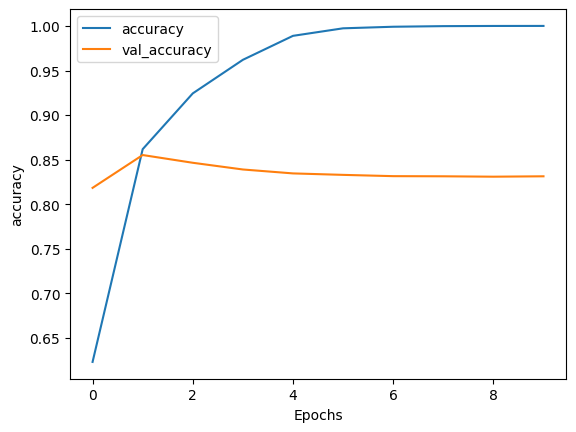

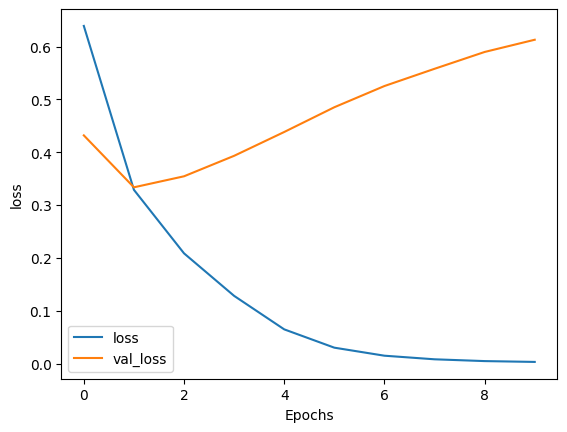

In [8]:
# Plot the accuracy and loss history
plot_graphs(history_flatten, 'accuracy')
plot_graphs(history_flatten, 'loss')

LSTM

This is slower to train but useful in applications where the order of the tokens is important.

In [9]:
embedding_dim=16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
model_lstm=tf.keras.Sequential([
           tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
           tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
           tf.keras.layers.Dense(dense_dim,activation='relu'),
           tf.keras.layers.Dense(1,activation='sigmoid')

])
# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [10]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 26s 119ms/step - loss: 0.5780 - accuracy: 0.6628 - val_loss: 0.3679 - val_accuracy: 0.8417
Epoch 2/10
196/196 [==============================] - 21s 109ms/step - loss: 0.3241 - accuracy: 0.8644 - val_loss: 0.3467 - val_accuracy: 0.8528
Epoch 3/10
196/196 [==============================] - 21s 106ms/step - loss: 0.2476 - accuracy: 0.9047 - val_loss: 0.3817 - val_accuracy: 0.8395
Epoch 4/10
196/196 [==============================] - 21s 105ms/step - loss: 0.2088 - accuracy: 0.9214 - val_loss: 0.3989 - val_accuracy: 0.8289
Epoch 5/10
196/196 [==============================] - 21s 108ms/step - loss: 0.1816 - accuracy: 0.9356 - val_loss: 0.3985 - val_accuracy: 0.8249
Epoch 6/10
196/196 [==============================] - 21s 108ms/step - loss: 0.1611 - accuracy: 0.9430 - val_loss: 0.4711 - val_accuracy: 0.8192
Epoch 7/10
196/196 [==============================] - 21s 105ms/step - loss: 0.1419 - accuracy: 0.9501 - val_loss: 0.5590 - val_ac

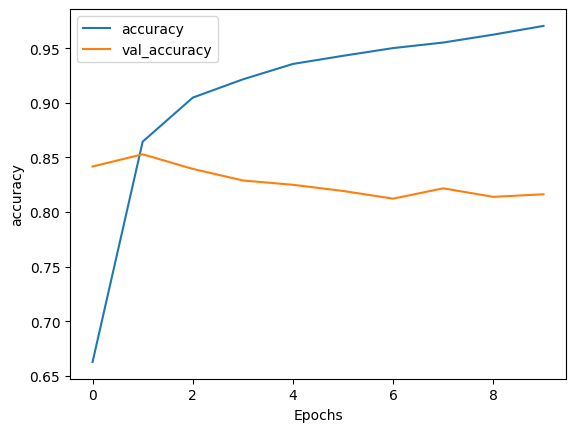

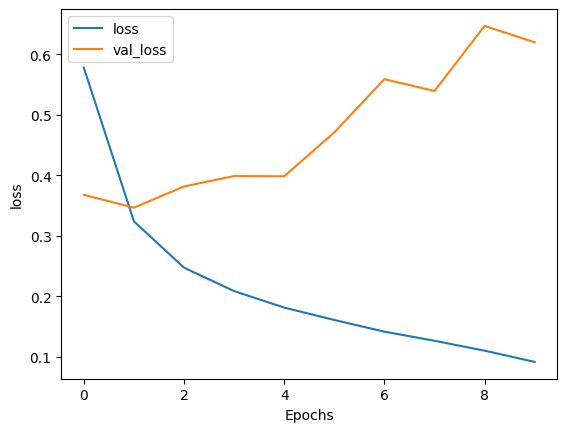

In [11]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

GRU

The Gated Recurrent Unit or GRU is usually referred to as a simpler version of the LSTM. It can be used in applications where the sequence is important but you want faster results and can sacrifice some accuracy. You will notice in the model summary that it is a bit smaller than the LSTM and it also trains faster by a few seconds.

In [12]:
import tensorflow as tf

# Parameters
embedding_dim = 16
gru_dim = 32
dense_dim = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])



In [13]:
# Print the model summary
model_gru.summary()
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_gru = model_gru.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 25s 112ms/step - loss: 0.5885 - accuracy: 0.6542 - val_loss:

Convolution

Lastly, you will use a convolution layer to extract features from your dataset. You will append a GlobalAveragePooling1d layer to reduce the results before passing it on to the dense layers. Like the model with Flatten, this also trains much faster than the ones using RNN layers like LSTM and GRU.

In [14]:
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_6 (Dense)             (None, 6)                 774       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

In [15]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_conv = model_conv.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 7s 31ms/step - loss: 0.5657 - accuracy: 0.6884 - val_loss: 0.3572 - val_accuracy: 0.8466
Epoch 2/10
196/196 [==============================] - 7s 34ms/step - loss: 0.3027 - accuracy: 0.8761 - val_loss: 0.3469 - val_accuracy: 0.8509
Epoch 3/10
196/196 [==============================] - 6s 30ms/step - loss: 0.2439 - accuracy: 0.9032 - val_loss: 0.3727 - val_accuracy: 0.8422
Epoch 4/10
196/196 [==============================] - 7s 34ms/step - loss: 0.2053 - accuracy: 0.9228 - val_loss: 0.4096 - val_accuracy: 0.8335
Epoch 5/10
196/196 [==============================] - 6s 30ms/step - loss: 0.1784 - accuracy: 0.9356 - val_loss: 0.4485 - val_accuracy: 0.8318
Epoch 6/10
196/196 [==============================] - 7s 35ms/step - loss: 0.1562 - accuracy: 0.9442 - val_loss: 0.4960 - val_accuracy: 0.8264
Epoch 7/10
196/196 [==============================] - 7s 35ms/step - loss: 0.1396 - accuracy: 0.9528 - val_loss: 0.5421 - val_accuracy: 0.8216

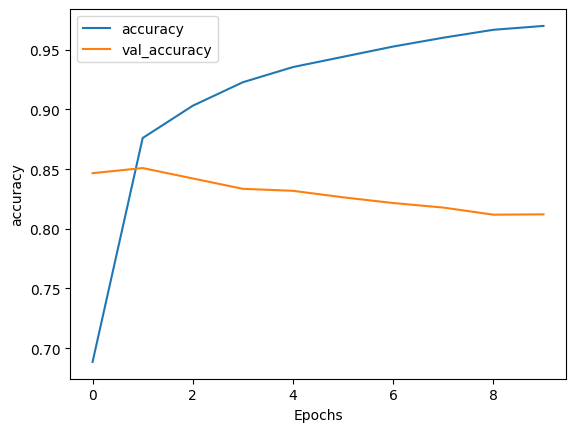

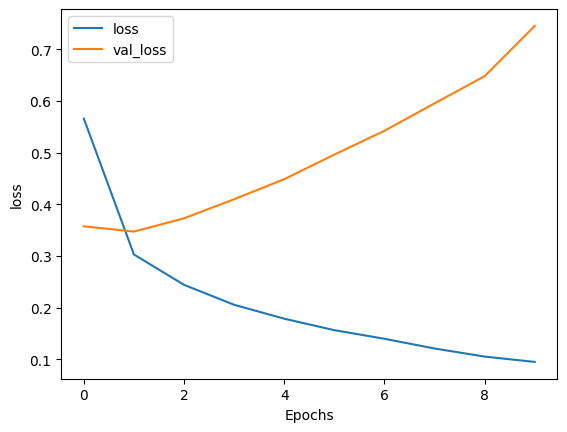

In [16]:
# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')